In [1]:
import os
import pandas as pd
from PIL import Image
from PIL.ExifTags import TAGS
import seaborn as sns
import torchvision.models as models
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision.models import resnet152,resnet50
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import zipfile
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
# Move to GPU if available
seed = 42
if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Load

In [3]:
dataset_path = "/kaggle/input/armansc/armanSc"
# List all image file paths and labels
data = []
for class_name in os.listdir(dataset_path):  # Iterate through class folders
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path) and class_name != 'glaucoma':  # Ensure it's a directory
        for img_file in os.listdir(class_path):  # Iterate images
            img_path = os.path.join(class_path, img_file)
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
                data.append([img_path, class_name])  # Store image path and class

# Convert to DataFrame
df = pd.DataFrame(data, columns=['image_path', 'class'])
df.head(5)

,image_path,class
0,/kaggle/input/armansc/armanSc/normal/2396_left...,normal
1,/kaggle/input/armansc/armanSc/normal/3017_left...,normal
2,/kaggle/input/armansc/armanSc/normal/3142_righ...,normal
3,/kaggle/input/armansc/armanSc/normal/2710_righ...,normal
4,/kaggle/input/armansc/armanSc/normal/1034_righ...,normal


In [4]:
for class_name in os.listdir(dataset_path):  # Iterate through class folders
    class_path = os.path.join(dataset_path, class_name)
    print(f"Class: {class_name}, Count: {len(os.listdir(class_path))}")

Class: normal, Count: 1074
Class: diabetic_retinopathy, Count: 1233
Class: cataract, Count: 1038


In [5]:
len(df)

3345

In [6]:
# prompt: print unique values in a df column
print(df['class'].value_counts())
class_names = df['class'].unique()
class_names

class
diabetic_retinopathy    1233
normal                  1074
cataract                1038
Name: count, dtype: int64


array(['normal', 'diabetic_retinopathy', 'cataract'], dtype=object)

In [7]:
Class_Label = {
    'normal':0,
    'diabetic_retinopathy':1,
    'cataract':2
}

In [8]:
df['label'] = df['class'].map(Class_Label)
df.head(5)

,image_path,class,label
0,/kaggle/input/armansc/armanSc/normal/2396_left...,normal,0
1,/kaggle/input/armansc/armanSc/normal/3017_left...,normal,0
2,/kaggle/input/armansc/armanSc/normal/3142_righ...,normal,0
3,/kaggle/input/armansc/armanSc/normal/2710_righ...,normal,0
4,/kaggle/input/armansc/armanSc/normal/1034_righ...,normal,0


## Dataset and Dataloader

In [9]:
def index_reset(df):
    return df.reset_index(drop=True)

def stratified_split(X, y, train_size=0.7, validation_size=0.15, test_size=0.15, random_state=42):

  X_train, X_temp, y_train, y_temp = train_test_split(
      X, y, test_size=(validation_size + test_size), stratify=y, random_state=random_state
  )
  X_train = X_train.reset_index(drop=True)

  validation_size_ratio = validation_size / (validation_size + test_size)

  X_val, X_test, y_val, y_test = train_test_split(
      X_temp, y_temp, test_size=1 - validation_size_ratio, stratify=y_temp, random_state=random_state
  )
  X_val = X_val.reset_index(drop=True)
  X_test = X_test.reset_index(drop=True)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
train_data, val_data, test_data, y_train, y_val, y_test = stratified_split(
    df, df['label'], train_size=0.8, validation_size=0.1, test_size=0.1
)
len(train_data),len(val_data),len(test_data),len(y_train),len(y_val),len(y_test)

(2676, 334, 335, 2676, 334, 335)

In [11]:
df.head(1)

,image_path,class,label
0,/kaggle/input/armansc/armanSc/normal/2396_left...,normal,0


In [12]:
class ArmanDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        label = self.df.iloc[idx]['label']
        class_name = self.df.iloc[idx]['class']


        return img_path, img, label, class_name

In [13]:
batch_size = 32
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [14]:
train_set = ArmanDataset(train_data, transform=transform)
val_set = ArmanDataset(val_data, transform=transform)
test_set = ArmanDataset(test_data, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## Image Metadata

In [15]:
image_path = df.iloc[0]['image_path']
print(image_path)

# Check if file exists
if os.path.exists(image_path):
    # Open Image
    img = Image.open(image_path)

    # Get Basic Metadata
    metadata = {
        "Filename": os.path.basename(image_path),
        "Format": img.format,
        "Mode": img.mode,
        "Size": img.size,  # (width, height)
    }

    # Extract EXIF Data (if available)
    exif_data = img._getexif()
    if exif_data:
        for tag_id, value in exif_data.items():
            tag_name = TAGS.get(tag_id, tag_id)
            metadata[tag_name] = value

    # Print Metadata
    for key, value in metadata.items():
        print(f"{key}: {value}")

else:
    print("Image not found! Please check the path.")

/kaggle/input/armansc/armanSc/normal/2396_left.jpg
Filename: 2396_left.jpg
Format: JPEG
Mode: RGB
Size: (512, 512)


## Model Load

In [16]:
# Load Pretrained ResNet-50
model = resnet50(weights=None)
# model

In [17]:
# Modify the Final Layer to Match Our Number of Classes
num_classes = len(class_names)  # Number of classes in dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify output layer
model = model.to(device)

## Hyperparameters

In [18]:
learning_rate = 0.000001
num_epoch = 150

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training Starts

In [19]:
train_statistics = []
max_acc = 0.0
best_loss = float('inf')
patience = 5  # Number of epochs to wait before stopping
counter = 0
model_name = './resnet50_ArmanSc'

for epoch in range(num_epoch):
    total_loss = 0
    corrects = 0
    # img_path, img, label, class_name
    # Training loop
    model.train()
    for img_paths, imgs, labels, class_names in tqdm(train_loader, desc=f'Train epoch: {epoch + 1}'):
        imgs = imgs.to(device)
        labels = labels.to(device)
        out = model(imgs)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(out, dim=1)
        corrects += torch.sum(preds == labels).item()

    train_accuracy = corrects / len(train_loader.dataset)
    train_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch + 1} | Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.2f}')

    # Validation loop
    total_loss = 0
    corrects = 0
    model.eval()
    with torch.no_grad():
        for img_paths, imgs, labels, class_names in tqdm(val_loader, desc=f'Validation epoch: {epoch + 1}'):
            imgs = imgs.to(device)
            labels = labels.to(device)

            out = model(imgs)
            loss = criterion(out, labels)
            total_loss += loss.item()

            preds = torch.argmax(out, dim=1)
            corrects += torch.sum(preds == labels).item()

        val_accuracy = corrects / len(val_loader.dataset)
        val_loss = total_loss / len(val_loader)

        print(f'Validation loss: {val_loss:.4f} | Accuracy: {val_accuracy:.2f}')

        train_statistics.append({
            'epoch': epoch + 1,
            'train_acc': train_accuracy,
            'train_loss': train_loss,
            'val_acc': val_accuracy,
            'val_loss': val_loss
        })

        # Check for best model (higher accuracy)
        if val_accuracy > max_acc:
            max_acc = val_accuracy
            torch.save(model.state_dict(), model_name)
            print("Model saved (improved accuracy)")


print("Training complete.")

Train epoch: 1:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.0801 | Accuracy: 0.41


Validation epoch: 1:   0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 1.0058 | Accuracy: 0.46
Model saved (improved accuracy)
Training complete.


In [20]:
train_stat_df = pd.DataFrame(train_statistics)

# Save the DataFrame to a CSV file
csv_filename = "train_statistics.csv"
train_stat_df.to_csv(csv_filename, index=False)

print(f"Train statistics saved to {csv_filename}")

Train statistics saved to train_statistics.csv


## Testing

In [21]:
total_loss = 0
corrects = 0
test_result = []
model.eval()

with torch.no_grad():
    for img_paths, imgs, labels, class_names in tqdm(test_loader):

        imgs = imgs.to(device)
        labels = labels.to(device)

        out = model(imgs)
        loss = criterion(out, labels)
        total_loss += loss.item()

        preds = torch.argmax(out, dim=1)
        corrects += torch.sum(preds == labels).item()
        test_result.append({
            'Label':labels.cpu().numpy(),
            'Pred': preds.cpu().numpy()
        })

    test_accuracy = corrects / len(test_loader.dataset)
    test_loss = total_loss / len(test_loader)

    print(f'Test loss: {test_loss:.4f} | Accuracy: {test_accuracy:.2f}')

  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 1.0427 | Accuracy: 0.46


In [22]:
test_result_stat_df = pd.DataFrame(test_result)

# Save the DataFrame to a CSV file
csv_filename = "test_result.csv"
test_result_stat_df.to_csv(csv_filename, index=False)

print(f"Test Results saved to {csv_filename}")

Test Results saved to test_result.csv


In [23]:
# Function to smooth data using a moving average
def smooth_curve(data, window_size=10):
    return data.rolling(window=window_size, min_periods=1).mean()

# Plotting, showing, and saving one smoothed curve at a time
def plot_show_and_save_curve(df, metric1, metric2, title, ylabel, filename, smoothing_window=10):
    plt.figure(figsize=(8, 5))
    plt.plot(df['epoch'], smooth_curve(df[metric1], smoothing_window), label=f'{metric1}', color='blue')
    plt.plot(df['epoch'], smooth_curve(df[metric2], smoothing_window), label=f'{metric2}', color='orange')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

    # Show and save the plot
    plt.show()  # Display the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save the figure
    plt.close()

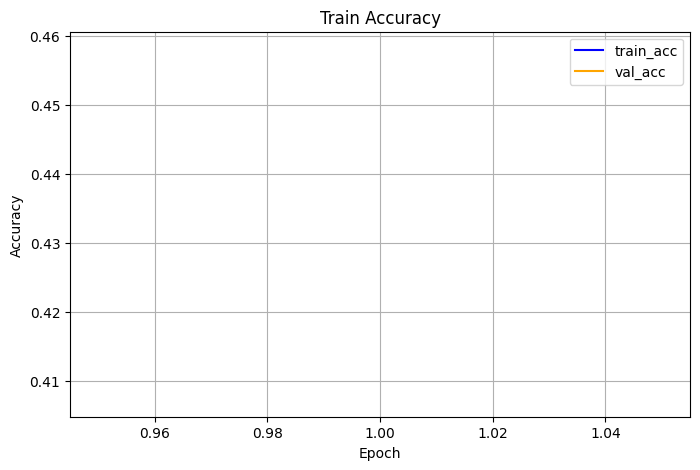

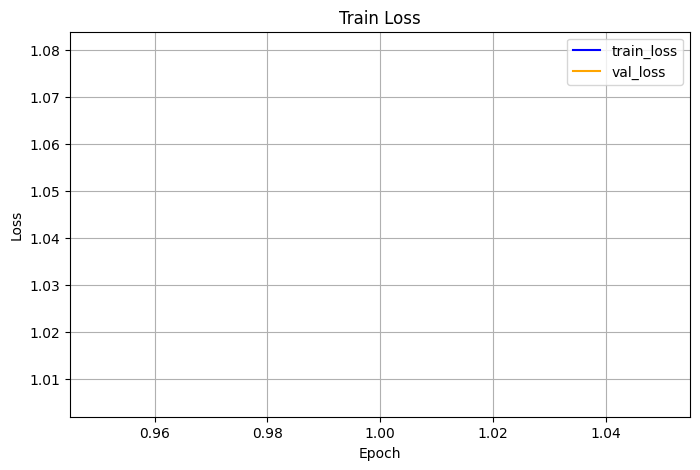

Plots displayed and saved as 'smoothed_accuracy.png' and 'smoothed_loss.png'


In [24]:
# Display and save smoothed accuracy plot
plot_show_and_save_curve(train_stat_df, 'train_acc', 'val_acc', 'Train Accuracy', 'Accuracy', 'train_accuracy.png')

# Display and save smoothed loss plot
plot_show_and_save_curve(train_stat_df, 'train_loss', 'val_loss', 'Train Loss', 'Loss', 'train_loss.png')

print("Plots displayed and saved as 'smoothed_accuracy.png' and 'smoothed_loss.png'")

In [25]:
pred_append_list = test_result_stat_df['Pred'].to_list()
label_append_list = test_result_stat_df['Label'].to_list()
pred_list = np.concatenate(pred_append_list).tolist()
label_list = np.concatenate(label_append_list).tolist()

In [26]:
label_name_list = [test_data.set_index('label')['class'].to_dict().get(i) for i in range(test_data['label'].max() + 1)]
# Print the result
print("Label Name List:", label_name_list)

Label Name List: ['normal', 'diabetic_retinopathy', 'cataract']


In [27]:
report = classification_report(label_list, pred_list, target_names=[f'{label_name_list[i]}' for i in range(3)])
print("Classification Report:")
print(report)

Classification Report:
                      precision    recall  f1-score   support

              normal       0.55      0.15      0.23       108
diabetic_retinopathy       0.43      0.92      0.59       124
            cataract       0.57      0.23      0.33       103

            accuracy                           0.46       335
           macro avg       0.52      0.43      0.38       335
        weighted avg       0.51      0.46      0.39       335



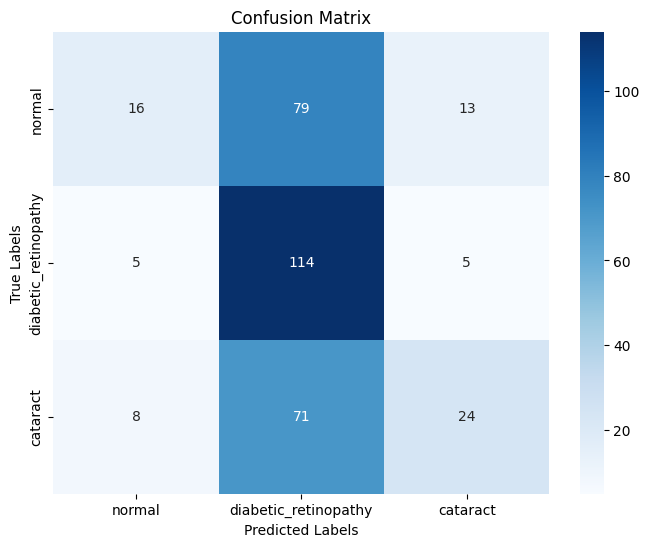

In [28]:
conf_matrix = confusion_matrix(label_list, pred_list)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_name_list, yticklabels=label_name_list)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

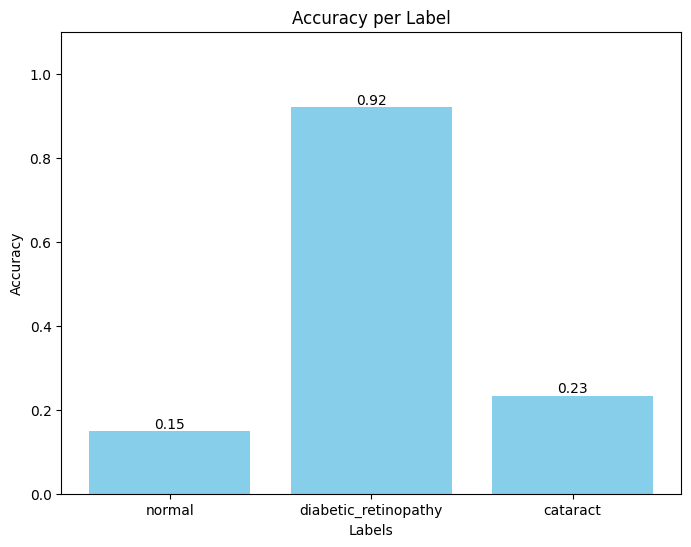

In [29]:
# Calculate accuracy per label
unique_labels = sorted(set(label_list))
label_accuracies = [np.mean([pred == label for pred, label in zip(pred_list, label_list) if label == lbl]) for lbl in unique_labels]

# Bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_labels, label_accuracies, color='skyblue')

# Add accuracy values on top of each bar
for bar, acc in zip(bars, label_accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height(),                   # Y-coordinate (height of the bar)
        f'{acc:.2f}',                       # Accuracy value with 2 decimal places
        ha='center', va='bottom', fontsize=10, color='black'
    )

# Customize plot
plt.xticks(unique_labels, [f'{label_name_list[i]}' for i in unique_labels])
plt.title('Accuracy per Label')
plt.xlabel('Labels')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)  # Extend y-axis slightly for better visualization
plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

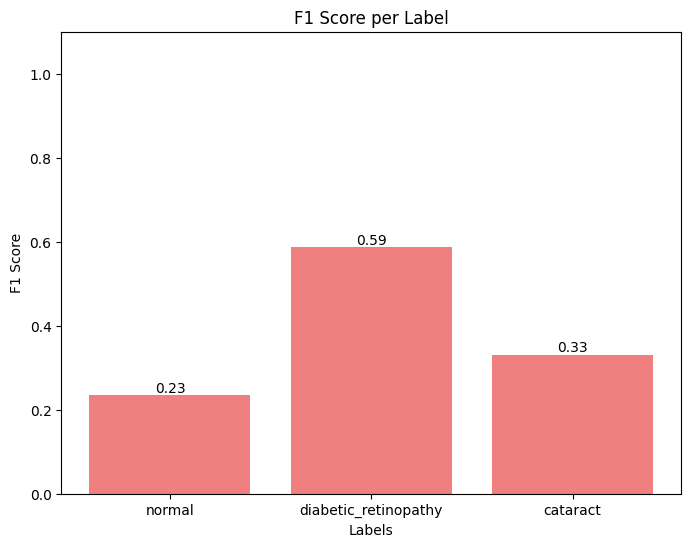

In [30]:
# Calculate F1 score per label
f1_scores = [
    f1_score([label == lbl for label in label_list], [pred == lbl for pred in pred_list], zero_division=0)
    for lbl in unique_labels
]

# Bar plot for F1 scores
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_labels, f1_scores, color='lightcoral')

# Add F1 score values on top of each bar
for bar, f1 in zip(bars, f1_scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height(),                   # Y-coordinate (height of the bar)
        f'{f1:.2f}',                        # F1 score value with 2 decimal places
        ha='center', va='bottom', fontsize=10, color='black'
    )

# Customize plot
plt.xticks(unique_labels, [f'{label_name_list[i]}' for i in unique_labels])
plt.title('F1 Score per Label')
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.ylim(0, 1.1)  # Extend y-axis slightly for better visualization
plt.savefig('f1_score_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

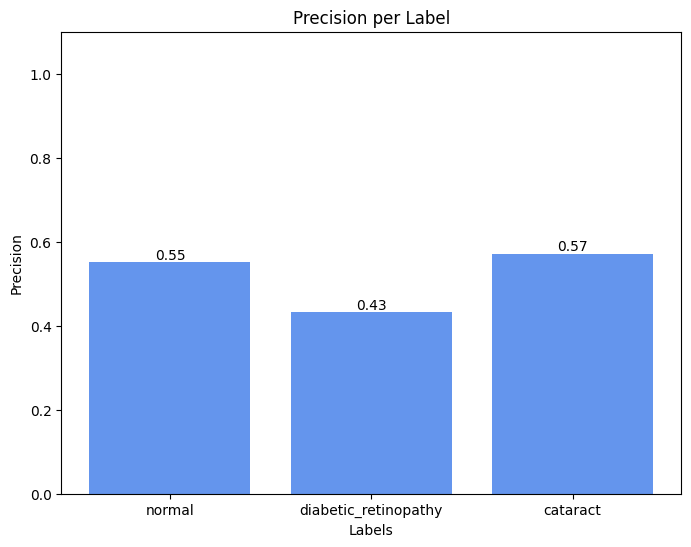

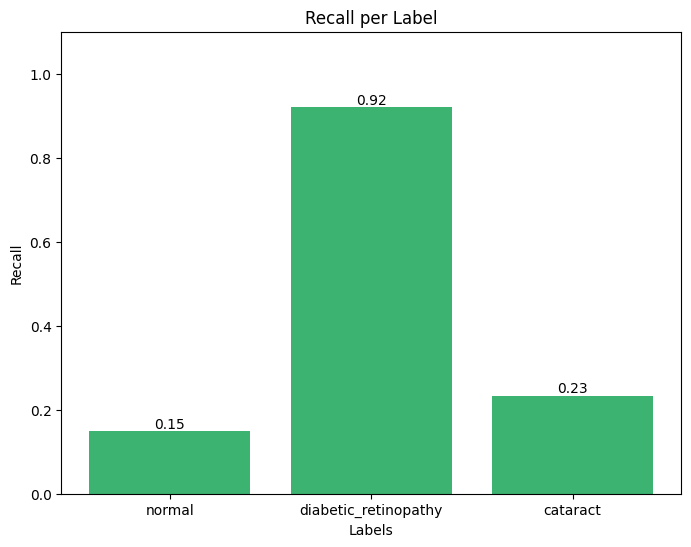

In [31]:
# Calculate precision and recall per label
precision_scores = [
    precision_score([label == lbl for label in label_list], [pred == lbl for pred in pred_list], zero_division=0)
    for lbl in unique_labels
]
recall_scores = [
    recall_score([label == lbl for label in label_list], [pred == lbl for pred in pred_list], zero_division=0)
    for lbl in unique_labels
]

# Bar plot for Precision
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_labels, precision_scores, color='cornflowerblue')
for bar, precision in zip(bars, precision_scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{precision:.2f}',
        ha='center', va='bottom', fontsize=10, color='black'
    )
plt.xticks(unique_labels, [f'{label_name_list[i]}' for i in unique_labels])
plt.title('Precision per Label')
plt.xlabel('Labels')
plt.ylabel('Precision')
plt.ylim(0, 1.1)
plt.savefig('precision_plot.png', dpi=300, bbox_inches='tight')  # Save plot
plt.show()

# Bar plot for Recall
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_labels, recall_scores, color='mediumseagreen')
for bar, recall in zip(bars, recall_scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{recall:.2f}',
        ha='center', va='bottom', fontsize=10, color='black'
    )
plt.xticks(unique_labels, [f'{label_name_list[i]}' for i in unique_labels])
plt.title('Recall per Label')
plt.xlabel('Labels')
plt.ylabel('Recall')
plt.ylim(0, 1.1)
plt.savefig('recall_plot.png', dpi=300, bbox_inches='tight')  # Save plot
plt.show()

In [32]:
def zipImages(image_files):
    # Path for the resulting ZIP file
    output_zip_path = "armanSC.zip"
    
    # Create a ZIP file
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for image in image_files:
            if os.path.exists(image):  # Ensure the file exists
                # Add the video file to the ZIP archive
                arcname = os.path.basename(image)  # Use just the filename in the archive
                zipf.write(image, arcname)
                print(f"Added {image} as {arcname}")
            else:
                print(f"File not found: {image}")
    
    print(f"All images zipped into {output_zip_path}")

In [33]:
imageFiles = []
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        imageFiles.append(os.path.join(dirname, filename))
zipImages(imageFiles)

Added /kaggle/working/f1_score_plot.png as f1_score_plot.png
Added /kaggle/working/resnet50 as resnet50
Added /kaggle/working/accuracy_plot.png as accuracy_plot.png
Added /kaggle/working/train_loss.png as train_loss.png
Added /kaggle/working/test_result.csv as test_result.csv
Added /kaggle/working/precision_plot.png as precision_plot.png
Added /kaggle/working/confusion_matrix.png as confusion_matrix.png
Added /kaggle/working/train_accuracy.png as train_accuracy.png
Added /kaggle/working/train_statistics.csv as train_statistics.csv
Added /kaggle/working/recall_plot.png as recall_plot.png
All images zipped into armanSC.zip
